<a href="https://colab.research.google.com/github/hyeonji826/AI/blob/main/%EA%B3%BC%EC%A0%9C/%EC%9D%B4%EC%83%81%ED%96%89%EB%8F%99_%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 파이프라인
1. 압축 해제
2. 프레임 추출 : OpenCV로 frame_skip=5 -> 프레임을 폴더화시킴
3. 데이터셋 구성 : VideoFrameseDataset
    - 시퀀스 길이 T=16
4. 전처리 : Resize(128) -> ToTensor()

In [1]:
import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm

# ------------------------------
# 1. Colab 드라이브 경로에 있는 데이터셋 압축 해제
# ------------------------------
zip_path = "/content/drive/MyDrive/AI활용 소프트웨어 개발/weird.zip"
extract_path = "/content/weird"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("데이터 압축 해제 완료:", extract_path)

데이터 압축 해제 완료: /content/weird


In [2]:
# ------------------------------
# 2. 동영상 → 프레임 변환 함수
# ------------------------------
def video_to_frames(video_path, out_dir, frame_skip=5):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    idx, frame_id = 0, 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        if idx % frame_skip == 0:
            frame_path = os.path.join(out_dir, f"{frame_id:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_id += 1
        idx += 1
    cap.release()

def prepare_frames(base_dir):
    for label in ["falling", "fire"]:
        src = os.path.join(base_dir, label)
        videos = [f for f in os.listdir(src) if f.endswith(".mp4")]
        for vid in videos:
            vid_path = os.path.join(src, vid)
            out_dir = os.path.join(src, vid.replace(".mp4",""))
            if not os.path.exists(out_dir):
                video_to_frames(vid_path, out_dir)
prepare_frames(extract_path)

# ------------------------------
# 3. Dataset 정의
# ------------------------------
class VideoFramesDataset(Dataset):
    def __init__(self, root_dir, seq_len=16, transform=None):
        self.samples, self.labels = [], []
        self.transform = transform
        self.seq_len = seq_len
        self.label_dict = {"falling": 0, "fire": 1}

        for label in self.label_dict:
            folder = os.path.join(root_dir, label)
            videos = os.listdir(folder)
            for vid in videos:
                vid_path = os.path.join(folder, vid)
                if not os.path.isdir(vid_path): continue
                frames = sorted(os.listdir(vid_path))
                if len(frames) >= seq_len:
                    self.samples.append((vid_path, frames))
                    self.labels.append(self.label_dict[label])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        vid_path, frames = self.samples[idx]
        selected = frames[:self.seq_len]
        imgs = []
        for f in selected:
            img = cv2.imread(os.path.join(vid_path, f))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transform:
                img = self.transform(img)
            imgs.append(img)
        imgs = torch.stack(imgs)  # [seq_len, C, H, W]
        return imgs, self.labels[idx]

# ------------------------------
# 4. 데이터셋 로드 및 train/val/test 분리 (70/15/15)
# ------------------------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

full_set = VideoFramesDataset(extract_path, transform=transform)
train_size = int(0.7 * len(full_set))
val_size   = int(0.15 * len(full_set))
test_size  = len(full_set) - train_size - val_size
train_set, val_set, test_set = random_split(full_set, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=4, shuffle=False)

print(f"데이터 분할 완료 → Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

데이터 분할 완료 → Train: 445, Val: 95, Test: 97


## 모델링
- Backbone : ResNet18 (layer3/4만 학습하고 나머지는 동결함)
- 시퀀스 인코더
- CLS 토큰 + 사인/코사인 포지셔널 인코딩함

    ### 학습
    1. 손실: CrossEntropy(weight=class_weights, label_smoothing=0.05)

    2. 옵티마이저: AdamW(lr=3e-4, weight_decay=1e-4)

    3. 스케줄러: Warmup(10%) + Cosine decay

    4. 안정화: AMP(mixed-precision), Gradient Clipping=1.0

    5. 정지 규칙: EarlyStopping(patience=5) + 베스트 체크포인트 저장

    6. 배치: 4

    7. 에폭: 20 내외 (EarlyStopping으로 조절)

In [6]:
# ------------------------------
# 5. Transformer 기반 모델 정의
# ------------------------------
import math, copy, torch
import torch.nn as nn
import contextlib
from torch import amp
from torchvision.models import resnet18, ResNet18_Weights

def _posenc_sincos_1d(T: int, dim: int, device, dtype):
    """1D sine-cosine positional encoding: [T, dim]"""
    pe = torch.zeros(T, dim, device=device, dtype=dtype)
    position = torch.arange(0, T, device=device, dtype=dtype).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2, device=device, dtype=dtype) * (-math.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # [T, dim]

class FrameTransformer(nn.Module):
    def __init__(self, seq_len=16, num_classes=2, dim=320, depth=4, heads=8, dropout=0.1):
        super().__init__()
        # 1) 사전학습 ResNet18 백본
        bb = resnet18(weights=ResNet18_Weights.DEFAULT)
        # backbone의 저층은 동결, layer3/4는 학습
        for name, p in bb.named_parameters():
            if not (name.startswith("layer3") or name.startswith("layer4")):
                p.requires_grad = False
        self.backbone = nn.Sequential(*list(bb.children())[:-2])  # conv..layer4 (pool/FC 제거)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # 512 x 4 x 4 (입력 128 기준)
        # 2) 프레임 임베딩 -> Transformer 차원으로
        self.linear = nn.Linear(512 * 4 * 4, dim)
        self.ln_in = nn.LayerNorm(dim)
        # 3) Transformer 인코더
        enc_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dropout=dropout, batch_first=False)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=depth)
        # 4) [CLS] 토큰과 출력 헤드
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.ln_out = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):  # x: [B, T, C, H, W]
        B, T, C, H, W = x.size()
        x = x.view(B*T, C, H, W)                       # [B*T, C, H, W]
        feats = self.backbone(x)                        # [B*T, 512, h, w]
        feats = self.pool(feats).flatten(1)             # [B*T, 512*4*4]
        feats = self.linear(feats)                      # [B*T, dim]
        feats = feats.view(B, T, -1).permute(1, 0, 2)   # [T, B, dim]

        # Positional encoding + CLS
        pe = _posenc_sincos_1d(T, feats.size(-1), feats.device, feats.dtype)  # [T, dim]
        feats = feats + pe.unsqueeze(1)                                       # [T, B, dim]
        cls = self.cls_token.expand(-1, B, -1)                                # [1, B, dim]
        seq = torch.cat([cls, feats], dim=0)                                   # [T+1, B, dim]

        out = self.transformer(seq)                                            # [T+1, B, dim]
        cls_out = self.ln_out(out[0])                                          # [B, dim]
        logits = self.fc(cls_out)                                              # [B, num_classes]
        return logits

# ------------------------------
# 6. 학습 함수 (개선: 가중치, 라벨 스무딩, 스케줄러, AMP, EarlyStopping)
# ------------------------------
def _compute_class_weights(loader, num_classes=2):
    counts = torch.zeros(num_classes)
    for _, y in loader:
        counts += torch.bincount(y, minlength=num_classes)
    counts = counts + 1e-6
    weights = (counts.sum() / (num_classes * counts))
    return weights.float()

def train_model(model, train_loader, val_loader, epochs=15, device="cuda",
                lr=3e-4, weight_decay=1e-4, warmup_ratio=0.1, patience=5):
    model.to(device)
    class_w = _compute_class_weights(train_loader, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=0.05)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    total_steps = epochs * len(train_loader)
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    scaler = amp.GradScaler('cuda') if device == "cuda" else None
    best_val, bad_epochs = -1.0, 0
    best_path = "/content/best_frame_transformer.pt"
    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    global_step = 0
    for epoch in range(1, epochs+1):
        model.train()
        total_loss, correct, n = 0.0, 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            # autocast 컨텍스트 (GPU면 fp16, CPU면 noop)
            ac = amp.autocast('cuda', dtype=torch.float16) if device == "cuda" else contextlib.nullcontext()
            with ac:
                logits = model(x)
                loss = criterion(logits, y)

            if scaler is not None:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            scheduler.step()
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            n += x.size(0)
            global_step += 1

        train_loss = total_loss / n
        train_acc = correct / n

        # --- validation ---
        model.eval()
        val_correct, val_n = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                val_correct += (logits.argmax(1) == y).sum().item()
                val_n += x.size(0)
        val_acc = val_correct / val_n

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch}: Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # --- early stopping & save best ---
        if val_acc > best_val:
            best_val = val_acc
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping triggered (no improve {patience} epochs). Best Val Acc={best_val:.4f}")
                break

    return history, best_path

# ------------------------------
# 7. 학습 실행 (베스트 체크포인트 저장)
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FrameTransformer(seq_len=16, num_classes=2, dim=320, depth=4, heads=8, dropout=0.1)
history, best_model_path = train_model(model, train_loader, val_loader,
                                       epochs=20, device=device,
                                       lr=3e-4, weight_decay=1e-4,
                                       warmup_ratio=0.1, patience=5)

Epoch 1/20: 100%|██████████| 112/112 [01:25<00:00,  1.32it/s]


Epoch 1: Loss=0.6585, Train Acc=0.6449, Val Acc=0.5684


Epoch 2/20: 100%|██████████| 112/112 [01:25<00:00,  1.32it/s]


Epoch 2: Loss=0.6728, Train Acc=0.7281, Val Acc=0.8211


Epoch 3/20: 100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 3: Loss=0.5047, Train Acc=0.8517, Val Acc=0.7579


Epoch 4/20: 100%|██████████| 112/112 [01:25<00:00,  1.32it/s]


Epoch 4: Loss=0.4481, Train Acc=0.8876, Val Acc=0.9474


Epoch 5/20: 100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 5: Loss=0.2634, Train Acc=0.9483, Val Acc=0.9474


Epoch 6/20: 100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 6: Loss=0.2520, Train Acc=0.9596, Val Acc=0.9684


Epoch 7/20: 100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 7: Loss=0.2995, Train Acc=0.9438, Val Acc=0.9368


Epoch 8/20: 100%|██████████| 112/112 [01:24<00:00,  1.32it/s]


Epoch 8: Loss=0.4137, Train Acc=0.9011, Val Acc=0.9053


Epoch 9/20: 100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 9: Loss=0.2086, Train Acc=0.9708, Val Acc=0.9368


Epoch 10/20: 100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 10: Loss=0.3206, Train Acc=0.9393, Val Acc=0.8632


Epoch 11/20: 100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 11: Loss=0.2564, Train Acc=0.9573, Val Acc=0.9053
Early stopping triggered (no improve 5 epochs). Best Val Acc=0.9684


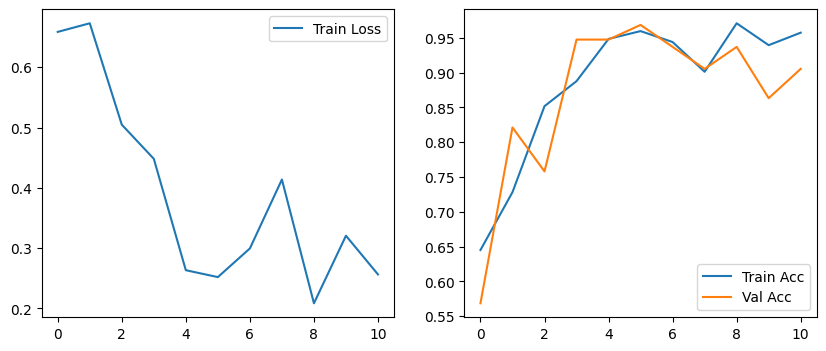

In [7]:
# ------------------------------
# 8. 학습 결과 시각화
# ------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label="Train Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label="Train Acc"); plt.plot(history["val_acc"], label="Val Acc"); plt.legend()
plt.show()

[TEST] Accuracy (TTA): 0.9381


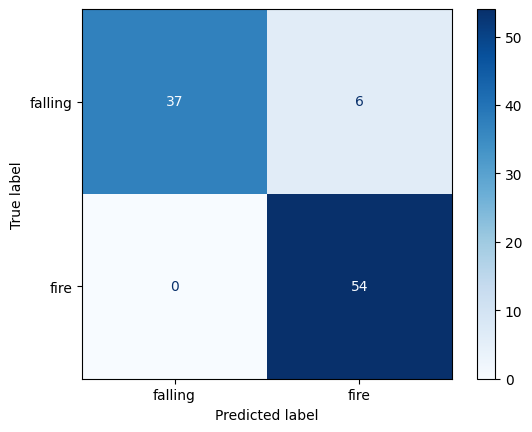

In [8]:
# ------------------------------
# 9. 테스트 평가 (베스트 로드 + TTA + Confusion Matrix)
# ------------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval(); model.to(device)

def predict_tta(x_batch):
    # x: [B,T,C,H,W]
    logits1 = model(x_batch)
    logits2 = model(x_batch.flip(-1))  # horizontal flip
    return (logits1 + logits2) / 2

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device); y_true.extend(y.numpy().tolist())
        logits = predict_tta(x)
        y_pred.extend(logits.argmax(1).cpu().numpy().tolist())

test_acc = accuracy_score(y_true, y_pred)
print(f"[TEST] Accuracy (TTA): {test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["falling","fire"])
disp.plot(cmap="Blues")
plt.show()

### 해석

falling: 37/43 맞춤 → 6건을 fire로 오탐

fire: 54/54 완벽히 탐지(미탐 0)

## Grad-CAM & 랜덤 테스트

대상 레이어: ResNet18 마지막 Conv 출력

절차: 타깃 로짓의 그라디언트로 채널 가중치 → 가중합 → ReLU → 업샘플·오버레이

랜덤 샘플러: test Subset에서 랜덤 시퀀스 n개 뽑아
‣ 예측/정답/확률 표시 + 시작/중간/끝 프레임 + 중간 프레임 Grad-CAM

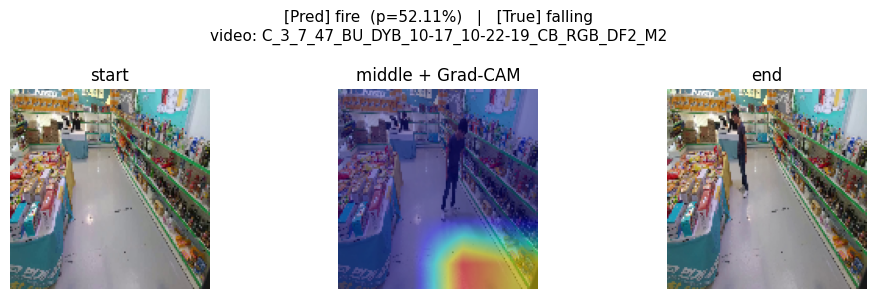

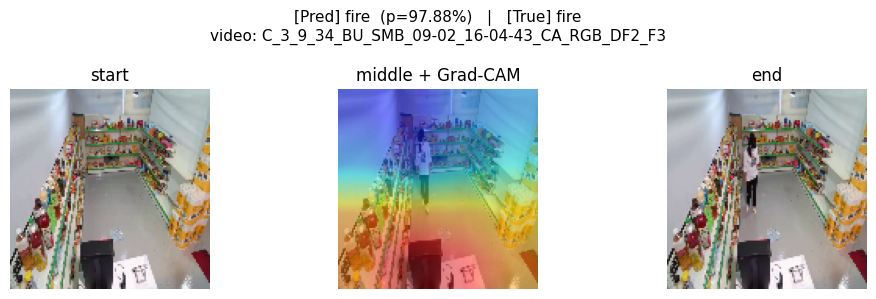

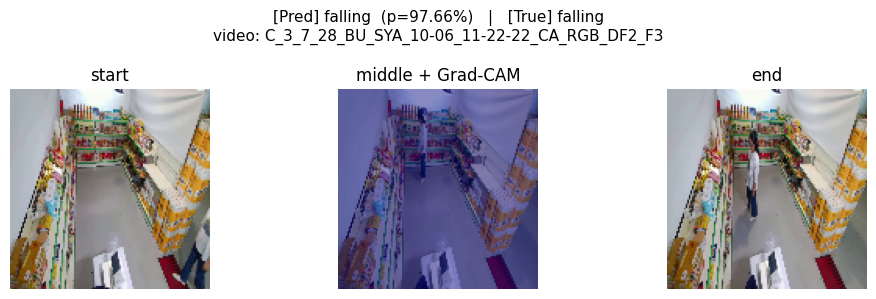

In [9]:
# ==== 랜덤 테스트 + Grad-CAM 시각화 ====
import random, math, contextlib, cv2, torch, numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

label_names = {0:"falling", 1:"fire"}

def _softmax(x):
    x = x - x.max(dim=1, keepdim=True).values
    e = torch.exp(x)
    return e / e.sum(dim=1, keepdim=True)

def predict_tta_batch(model, x):
    # x: [B,T,C,H,W]
    logits1 = model(x)
    logits2 = model(x.flip(-1))  # horizontal flip
    return (logits1 + logits2) / 2

def gradcam_single_sequence(model, seq_tensor, target_class, mid_idx=None):
    """
    seq_tensor: [1,T,C,H,W] on device
    returns: cam(np.float32, H, W) in [0,1]
    """
    model.eval()
    device = next(model.parameters()).device
    seq_tensor = seq_tensor.to(device)

    feats_holder = {}
    grads_holder = {}

    def fwd_hook(module, inp, out):
        feats_holder['feats'] = out.detach()               # [B*T, C, h, w]
        # retain grad on 'out'
        out.register_hook(lambda g: grads_holder.setdefault('grads', g.detach()))

    hook = model.backbone.register_forward_hook(fwd_hook)

    # 두 번째 패스: grad 필요하므로 autocast/grad 관리
    with torch.enable_grad():
        logits = model(seq_tensor)
        if target_class is None:
            target_class = int(logits.argmax(1).item())
        loss = logits[0, target_class]
        loss.backward()

    hook.remove()

    feats = feats_holder['feats']                         # [B*T, C, h, w]
    grads = grads_holder['grads']                         # [B*T, C, h, w]
    B, T = 1, seq_tensor.size(1)
    C, h, w = feats.size(1), feats.size(2), feats.size(3)
    feats = feats.view(T, C, h, w)                        # [T,C,h,w]
    grads = grads.view(T, C, h, w)

    if mid_idx is None:
        mid_idx = T // 2

    F = feats[mid_idx]                                    # [C,h,w]
    G = grads[mid_idx]                                    # [C,h,w]
    weights = G.mean(dim=(1,2), keepdim=True)             # [C,1,1]
    cam = (weights * F).sum(dim=0)                        # [h,w]
    cam = torch.relu(cam)
    cam = cam / (cam.max() + 1e-6)
    return cam.detach().cpu().numpy()                     # [h,w] in [0,1]

def overlay_heatmap(img_rgb, cam, alpha=0.45):
    # img_rgb: HxWx3 (uint8), cam: hxw in [0,1] -> resize to HxW
    H,W,_ = img_rgb.shape
    cam_resized = cv2.resize(cam, (W,H))
    heat = (cam_resized * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    over = (alpha*heat + (1-alpha)*img_rgb).astype(np.uint8)
    return over

def show_random_tests(n=3, use_gradcam=True):
    assert hasattr(test_set, "indices"), "test_set이 Subset이어야 합니다."
    global model
    device = next(model.parameters()).device
    model.eval()

    for k in range(n):
        # 1) 무작위 샘플 선택 (Subset → 원본 인덱스)
        orig_idx = random.choice(test_set.indices)
        vid_path, frames = full_set.samples[orig_idx]
        y_true = full_set.labels[orig_idx]
        T = full_set.seq_len
        selected = frames[:T]
        # 2) 시퀀스 텐서 구성 + 원본 이미지(시각화용) 로드
        imgs_t, imgs_rgb = [], []
        for f in selected:
            p = os.path.join(vid_path, f)
            img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
            imgs_rgb.append(cv2.resize(img, (128,128)))
            imgs_t.append(transform(img))                 # C,H,W
        seq = torch.stack(imgs_t).unsqueeze(0).to(device) # [1,T,C,H,W]

        # 3) 예측 (TTA)
        with torch.no_grad():
            logits = predict_tta_batch(model, seq)
            probs = _softmax(logits).squeeze(0).cpu().numpy()
            y_pred = int(np.argmax(probs))
            p_pred = float(probs[y_pred])

        # 4) Grad-CAM (가운데 프레임)
        mid = T//2
        if use_gradcam:
            cam = gradcam_single_sequence(model, seq.clone(), target_class=y_pred, mid_idx=mid)
            cam_img = overlay_heatmap(imgs_rgb[mid].copy(), cam)
        else:
            cam_img = imgs_rgb[mid]

        # 5) 시각화 (첫/중간/마지막 프레임)
        plt.figure(figsize=(10,3))
        plt.suptitle(f"[Pred] {label_names[y_pred]}  (p={p_pred:.2%})   |   [True] {label_names[y_true]}\n"
                     f"video: {os.path.basename(vid_path)}", fontsize=11)

        ax1 = plt.subplot(1,3,1); ax1.imshow(imgs_rgb[0]);  ax1.set_title("start"); ax1.axis("off")
        ax2 = plt.subplot(1,3,2); ax2.imshow(cam_img);       ax2.set_title("middle + Grad-CAM"); ax2.axis("off")
        ax3 = plt.subplot(1,3,3); ax3.imshow(imgs_rgb[-1]);  ax3.set_title("end"); ax3.axis("off")
        plt.tight_layout(); plt.show()

#  3개 랜덤 샘플 확인
try:
    model.load_state_dict(torch.load(best_model_path, map_location=next(model.parameters()).device))
except Exception as e:
    print("체크포인트 로드는 건너뜁니다:", e)

show_random_tests(n=3, use_gradcam=True)